In [1]:
import sys
sys.version
sys.executable

'/home/mike/anaconda3/bin/python'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
#import imutils
import numpy as np
from lxml import etree

from os import listdir
from os.path import isfile, join
from datetime import datetime

import tensorflow as tf
from keras import backend as K

from keras.models import model_from_json
from keras import optimizers

from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [3]:
import socket
hostname=socket.gethostname()

file="1133"
if hostname=="cellar2":
    SCENE_DIR="/media/winpart/drone/upairtag/"
    ANNO_DIR="/media/winpart/drone/labels/"
else:
    SCENE_DIR="/part/data/upairdrone/upairtag/"
    ANNO_DIR="/part/data/upairdrone/labels/"
    
    
scenefile=join(SCENE_DIR,file+".jpg")

## VGG16 GAP model

In [4]:
modeldir="./"
model_json=join(modeldir,"vgg16-GAP.v3_arch.json")
model_weight=join(modeldir,"vgg16-GAP.v3weights.h5")

In [5]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    model = model_from_json(f.read())

model.load_weights(model_weight)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

## VGG16 Classifier model

In [6]:
model_json=join(modeldir,"vgg16-fc1-fc2-12_arch.json")
model_weight=join(modeldir,"vgg16_weights.h5")

In [7]:
# Model reconstruction from JSON file
with open(model_json, 'r') as f:
    vggmodel = model_from_json(f.read())

vggmodel.load_weights(model_weight)

# Compile the model
vggmodel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

## Image visualisation

In [8]:
from matplotlib.pyplot import figure

def show_rgb_equalized(image):
    h,w,c=image.shape
    if h*w>140000:
        figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
        
    channels = cv2.split(image)
    eq_channels = []
    for ch, color in zip(channels, ['R', 'G', 'B']):
        eq_channels.append(cv2.equalizeHist(ch))

    eq_image = cv2.merge(eq_channels)
    plt.imshow(eq_image)
    plt.show()

def show_rgb(image):
    h,w,c=image.shape
    if h*w>140000:
        figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
        
    plt.imshow(image)
    plt.show()    

### Example of Scene Image

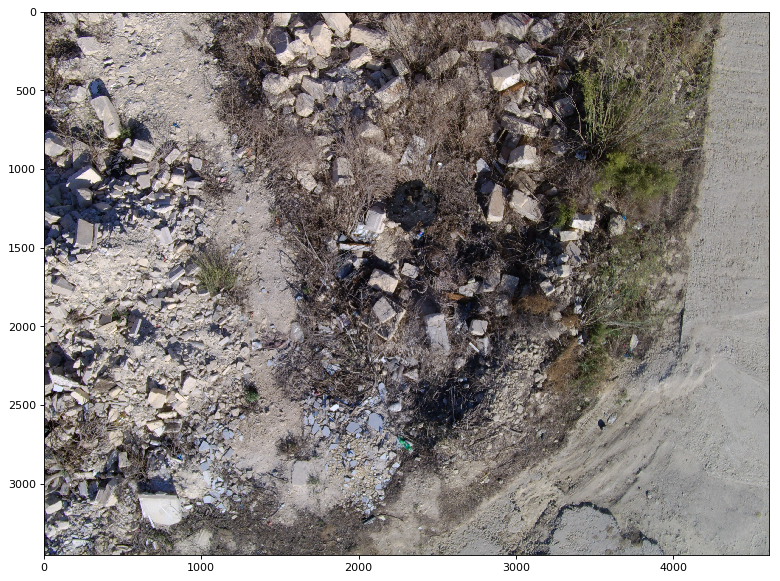

In [9]:
fullimage = cv2.imread(scenefile)
fullimage = cv2.cvtColor(fullimage, cv2.COLOR_BGR2RGB)

show_rgb(fullimage)

### Example of Image Tile and VGG16 CAM Single Prediction

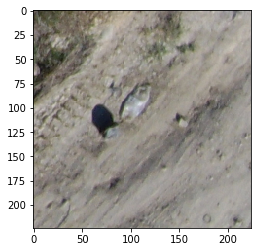

Image contained litter =  True


In [10]:
crop_image_size=448
image_size=224
x=3400
y=2400
crop_image=fullimage[y:y+crop_image_size,x:x+crop_image_size]
crop_image = cv2.resize(crop_image, (image_size, image_size))

#crop_image = crop_image.astype("float") / 255.0
img = img_to_array(crop_image.astype("float") / 255.0)
exp_img = np.expand_dims(img, axis=0)

show_rgb(crop_image)
preds=model.predict(exp_img)
print("Image contained litter = ",preds[0][1]>0.5)

## CAM methods

### VGG16 - CAM function with visualisation
- CAM requires model output
- Convulutional output feature map
- Subsequent layer Weights

In [11]:
for i in model.layers:
    if i.name=="conv6":
        output=i.output
    if i.name=="batch_normalization_11":
        classw=i.get_weights()[0]

get_output = K.function([model.input], [output, model.layers[-1].output])

def cam(img_in,crop_image,model):
    
    exp_img=img_in.copy()
    
    [conv_output,preds]=get_output([exp_img])
    print("Prediction Accuracy ",preds)
    
    cam = np.zeros(dtype = np.float32, shape = conv_output.shape[1:3])
    for i, w in enumerate(classw[:]):
        cam+=w*conv_output[0,:,:,i]

    print("Maximum value in heatmap ",np.max(cam))
    cam /=np.max(cam)
    
    width=height=image_size
    cam = cv2.resize(cam, (height, width))
    image = crop_image.copy()
    heatmap = np.ones((height,width,3), np.uint8)*255
    heatmap[np.where(cam < 0.8)] = 0
    
    thresh = cv2.threshold(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY), 60, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[1] 
    
    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        dist=0
        for [a] in c:
            dist=max(dist,(a[0]-cX)**2+(a[1]-cY)**2)
            
        radius=int(dist**0.5)
        # draw the contour and center of the shape on the image
        #cv2.drawContours(image, [c], -1, (0, 255, 0), 1)
        cv2.circle(image, (cX, cY), radius, (0, 255, 0), 2)
        cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
        
        print(radius)
        

    plt.imshow(image)
    plt.show()
        

    

### VGG16-CAM function returning bounding areas (circles)

In [12]:
def cam_centres(img_in,model,tilex,tiley,debug=False):
    exp_img=img_in.copy()
    [conv_output,preds]=get_output([exp_img])
        
    cam = np.zeros(dtype = np.float32, shape = conv_output.shape[1:3])
    for i, w in enumerate(classw[:]):
        cam+=w*conv_output[0,:,:,i]

    cam /=np.max(cam)
    
    width=height=image_size
    cam = cv2.resize(cam, (height, width))
    heatmap = np.ones((height,width,3), np.uint8)*255
    
    ### IMPORTANT THRESHOLD VALUE
    heatmap[np.where(cam < 0.75)] = 0
    
    thresh = cv2.threshold(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY), 60, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[1] 
    
    centres=[]
    cnt=0
    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"]!=0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX=0
            cY=0
            print("++++++++ERROR+++++++",cnt,len(cnts))
            print(exp_img.shape)
            show_rgb(exp_img[0])
            print(heatmap.shape)
            show_rgb(heatmap)
            print("=======================")
        
        if debug==True:
            print("++++++++DEBUG+++++++",cnt,len(cnts))
            show_rgb(exp_img[0])
            show_rgb(heatmap)
            print("=======================")
        
        dist=0
        for [a] in c:
            dist=max(dist,(a[0]-cX)**2+(a[1]-cY)**2)
            
        ## Small contours are discarded
        ## *2 = scale
        radius=int(dist**0.5)
        if radius>30:
            centres.append([cX*2+tilex,cY*2+tiley,radius,preds[0][1]])
        cnt=cnt+1
        
    if debug:
        print(centres)
        heatmap=exp_img[0]
        heatmap[np.where(cam < 0.75)] = 0
        show_rgb(heatmap)
        
    return centres

### VGG Affine Prediction
- Uses a VGG16 conv block and neural network for classifier

In [13]:
def VGGaffine(sceneimage,cx,cy,show=False,by_threshold=False, debug=False):
    
    height,width,chan = sceneimage.shape
    
    x1=max(0,cx-112)
    y1=max(0,cy-112)
    x2=min(x1+224,width)
    y2=min(y1+224,height)
    
    if (x2-x1)==224 and (y2-y1)==224:
        crop=sceneimage[y1:y2,x1:x2]
    elif (x2-x1)>40 and (y2-y1)>40:
        crop=cv2.resize(sceneimage[y1:y2,x1:x2],(224,224))
    else:
        return -1
    
    img = img_to_array(crop.astype("float") / 255.0)
    exp_img = np.expand_dims(img, axis=0)
    
    confidence=round(vggmodel.predict(exp_img)[0][1],3)
    
    if show==True:
        
        if debug:
            print("---------------------------------")
            print("VGGaffine Confidence:",confidence)
        if (by_threshold==True and confidence>0.5) or (by_threshold==False):
            show_rgb(crop)
        
    return confidence

### Example of 
1. VGG16 CAM on tile
2. Bounding Box result and
3. Affine prediction with visualisation

Prediction Accuracy  [[  7.19341324e-06   9.99992847e-01]]
Maximum value in heatmap  89296.7
37


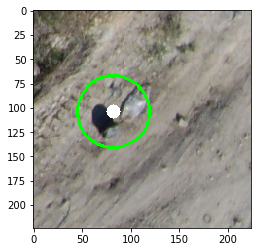

++++++++DEBUG+++++++ 0 1


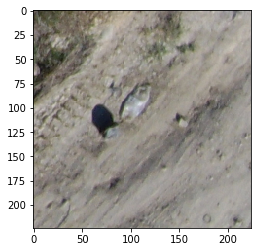

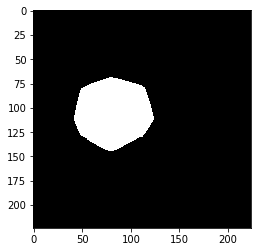

[[3562, 2610, 42, 0.99999285]]


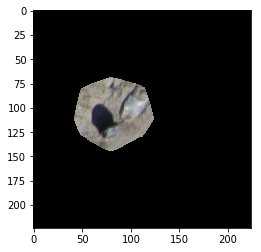

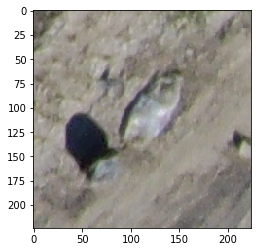

1.0

In [14]:
cam(exp_img,crop_image,model)
cam_centres(exp_img,model,3400,2400,debug=True)
VGGaffine(fullimage,3600,2600,True)

### Sliding Window with VGG16CAM output 

In [15]:
crop_image_size=448
image_size=224
image_height,image_width,chan = fullimage.shape

In [16]:
def find_individual_intereset_tiles():
    for x in range(0,image_width,crop_image_size-150):
        for y in range(0,image_height,crop_image_size-150):

            crop_image=fullimage[y:y+crop_image_size,x:x+crop_image_size]

            crop_image = cv2.resize(crop_image, (image_size, image_size))
            img = img_to_array(crop_image.astype("float") / 255.0)
            exp_img = np.expand_dims(img, axis=0)

            preds=model.predict(exp_img)[0][1]

            if preds>0.7 :
                print(x,y)
                cam(exp_img,crop_image,model)
                
                for a in cam_centres(exp_img,model,x,y):
                    print("Affine Confidence :",VGGaffine(fullimage,a[0],a[1],True))
                    print("--------------------------")
                
#find_individual_intereset_tiles()

### Sliding Window with VGG16CAM output  filtered  by Affine Classifier

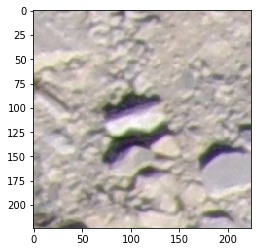

Litter found: [416, 320, 46, 0.96152747] 1.0 13


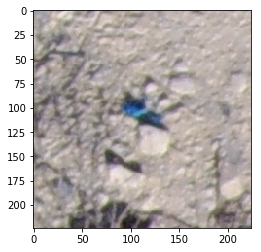

Litter found: [840, 734, 41, 0.99015057] 1.0 27


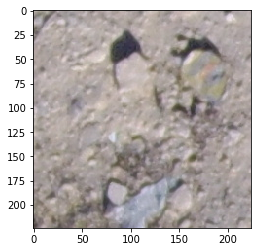

Litter found: [1224, 1414, 81, 0.99773812] 0.968 41


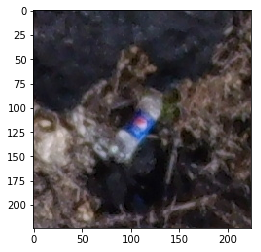

Litter found: [2396, 1408, 45, 0.99988866] 1.0 89


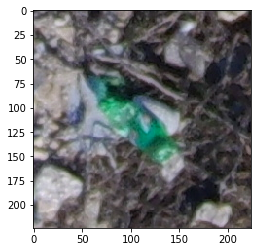

Litter found: [2302, 2750, 45, 0.99446785] 1.0 93


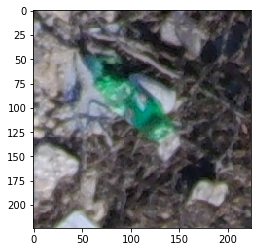

Litter found: [2306, 2772, 45, 0.85602337] 1.0 94


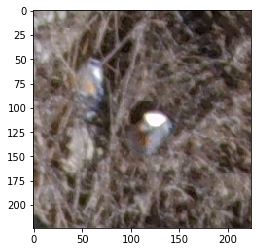

Litter found: [2502, 970, 42, 0.99992979] 1.0 100


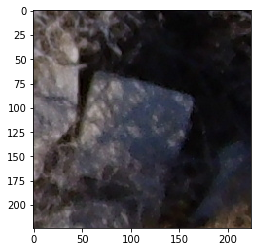

Litter found: [2966, 1718, 52, 0.77611595] 0.928 114
Prediction Accuracy  [[  3.04047694e-06   9.99996901e-01]]
Maximum value in heatmap  92385.3
38


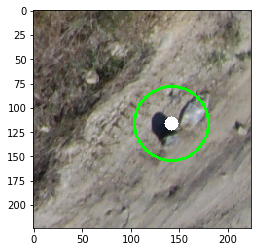

++++++++DEBUG+++++++ 0 1


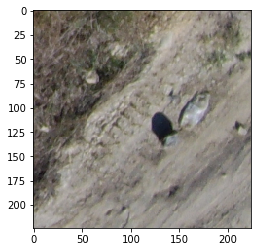

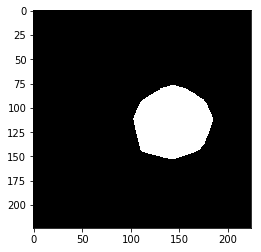

[[3562, 2614, 42, 0.9999969]]


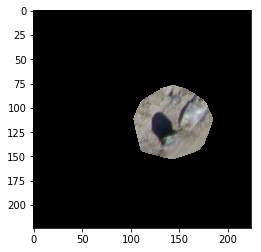

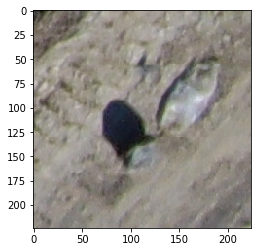

Litter found: [3562, 2614, 42, 0.9999969] 1.0 141


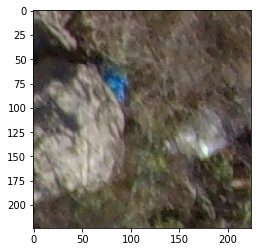

Litter found: [3714, 1350, 57, 0.80578053] 1.0 149


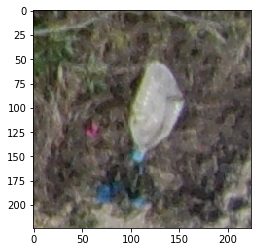

Litter found: [3736, 2114, 43, 0.97178978] 1.0 151


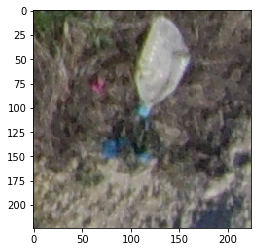

Litter found: [3730, 2160, 42, 0.76370627] 1.0 152
0:03:05.367677


In [17]:
start = datetime.now()
image_size=224


# Sliding Window with overlap
# Field Of View expanded from crop_image_size=448 tiles

def detect_litter(file,image,crop_image_size=448):
    bounding=[]
    image_height,image_width,chan = image.shape

    cnt=0
    for x in range(0,image_width,crop_image_size-150):
        for y in range(0,image_height,crop_image_size-150):

            cnt=cnt+1
            
            #Get Tile from Image
            crop_image=image[y:y+crop_image_size,x:x+crop_image_size]

            # Resize to 224x224
            crop_image = cv2.resize(crop_image, (image_size, image_size))
            img = img_to_array(crop_image.astype("float") / 255.0)
            exp_img = np.expand_dims(img, axis=0)

            # Get CAM prediction
            preds=model.predict(exp_img)[0][1]

            # If above Confidence Level 0.7
            if preds>0.7 :
                #Get contours
                if cnt!=141:
                    centres=cam_centres(exp_img,model,x,y)
                else:
                    cam(exp_img,crop_image,model)
                    centres=cam_centres(exp_img,model,x,y,debug=True)
                for c in centres:
                    
                    affine_confidence=VGGaffine(image,c[0],c[1],show=True,by_threshold=True)
                    if affine_confidence>0.5:
                        
                        print("Litter found:",c,affine_confidence,cnt)
                        [b1,b2,b3,b4]=c
                        bounding.append([file,b1,b2,b3,b4,affine_confidence])
    last_centre=[]
    
    ## Non Maxima Suppression of intersecting circles
    ## Intersection is when distance between centres is less than radius of circles
    for index in range(len(bounding)):
        [file,x,y,r,c,affince_confidence] = bounding[index]

        found=bounding[index]

        for index2 in range(len(bounding)):

            [file1,x1,y1,r1,c1,affine_confidence1] = bounding[index2]

            ## if later confidence is larger than current confidence
            if c1>c and (((x1-x)**2)+((y1-y)**2)<r*r) and index!=index2:
                found=None # Remove centre from list

        if found!=None:
            last_centre.append(found)
            
    
    return last_centre

bounding = detect_litter(file,fullimage,448)
    
print(datetime.now()-start)

### Display Bounding Areas and Ground_Truth in the Scene 

In [18]:
def parseXML(file):
    """
    Parse the xml
    """
    annofile=join(ANNO_DIR,file+".xml")
    if not isfile(annofile):
        ## File Does not exit return null ground-truth boxes.
        return []

    gt_box=[]
    with open(annofile) as fobj:
        xml = fobj.read()

    root = etree.fromstring(xml)

    for appt in root.getchildren():
        for elem in appt.getchildren():
            
            if elem.tag == "bndbox":
                for bb in elem.getchildren():
                    if not bb.text:
                        text = "None"
                    else:
                        if bb.tag=="xmin": xn=int(bb.text)
                        if bb.tag=="ymin": yn=int(bb.text)
                        if bb.tag=="xmax": xx=int(bb.text)
                        if bb.tag=="ymax": yx=int(bb.text)
                gt_box.append([xn,yn,xx,yx])
    return gt_box
ground_truth=parseXML(file)

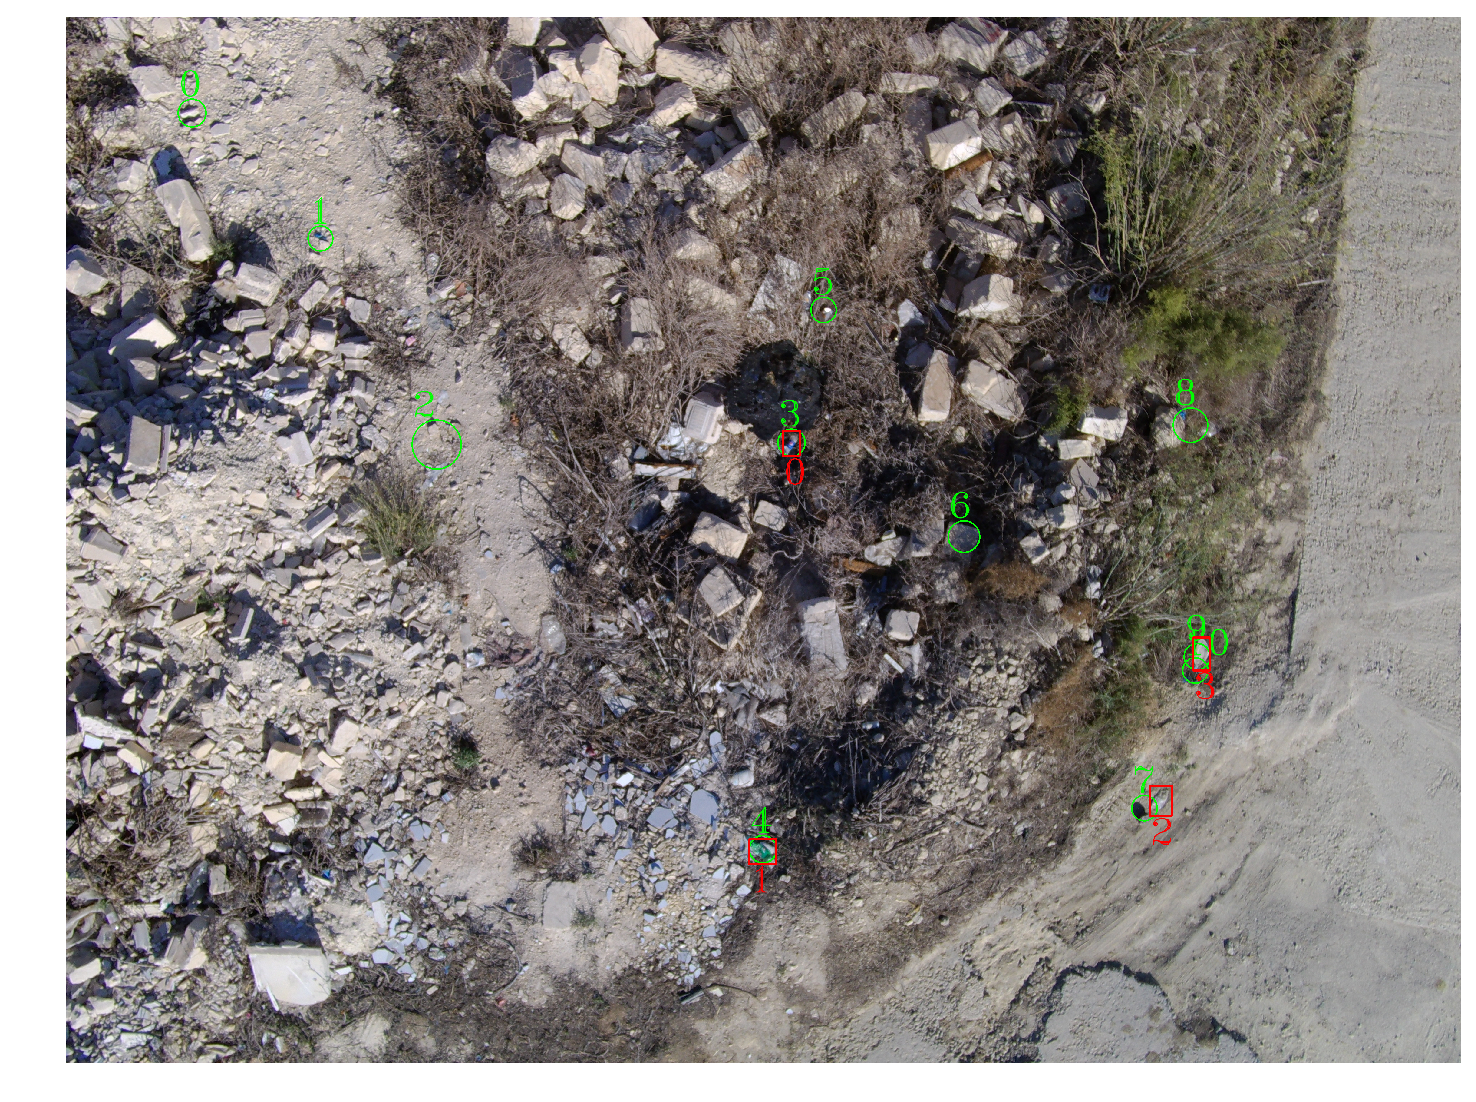

In [19]:
def show_predictions_and_groundtruth(bounding,gt,orig_image):
    showimage=orig_image.copy()
    font = cv2.FONT_HERSHEY_TRIPLEX
    
    cnt=0
    for c in bounding:
        [file,x,y,r,c,confidence] = c
        cv2.circle(showimage,(x,y),r,(0,255,0),4)
        cv2.putText(showimage,str(cnt),(x-r,y-10-r), font, 4,(0,255,0),2,cv2.LINE_AA)
        cnt=cnt+1
    
    cnt=0
    for i in gt:
        x0,y0,x1,y1=i
        cv2.rectangle(showimage,(x0,y0),(x1,y1),(255,0,0),6)
        cv2.putText(showimage,str(cnt),(x0,y1+r+50), font, 4,(255,0,0),2,cv2.LINE_AA)
        cnt=cnt+1
        
    figure(num=None, figsize=(15, 12), dpi=120, facecolor='w', edgecolor='k')

    plt.imshow(showimage)
    plt.axis('off')
    plt.show()
    cv2.imwrite("bb.png",cv2.cv2.cvtColor(showimage, cv2.COLOR_BGR2RGB))

image=fullimage.copy()
show_predictions_and_groundtruth(bounding,ground_truth,image)

## Define IoU

In [20]:
def area(box):
    x1,y1,x2,y2 = box
    return int((((x2-x1)**2+(y2-y1)**2))**(0.5))

def intersection(pred_box,gt_boxes):
    x1,y1,x2,y2 = pred_box
    ax=x1
    ay=y1
    bx=x2
    by=y2
    
    boxfound=[0,0,0,0,-1,0]
    for boxno in range(len(gt_boxes)):
        a = gt_boxes[boxno]
        xx1, yy1, xx2, yy2 = a
        
        out_of_bounds=False
        if xx1>x1 and xx1>x2 and xx2>x1 and xx2>x2:
            out_of_bounds=True
            
        if xx1<x1 and xx1<x2 and xx2<x1 and xx2<x2:
            out_of_bounds=True
            
        if yy1>y1 and yy1>y2 and yy2>y1 and yy2>y2:
            out_of_bounds=True
            
        if yy1<y1 and yy1<y2 and yy2<y1 and yy2<y2:
            out_of_bounds=True
        
        if out_of_bounds==False:
            
            ##  if the boxes intersect than the intersection values
            ## are given by the middle sorted values
            xvalues=[x1,x2,xx1,xx2]
            yvalues=[y1,y2,yy1,yy2]
            xvalues.sort()
            yvalues.sort()
            [ax,bx]=xvalues[1:3]
            [ay,by]=yvalues[1:3]
            
            if [ax,ay,bx,by]!=pred_box:

                intersectionarea=area([ax,ay,bx,by])
                if intersectionarea > boxfound[5]:
                    boxfound=[ax,ay,bx,by,boxno,intersectionarea]
    
    return boxfound

In [21]:
def iou(boundbox,gt_boxes):
    I=intersection(boundbox,gt_boxes)
    
    if I[4]>-1:
        
        ### If TP has been found then calculate Union and Intersection Over Union
        Union = area(gt_boxes[I[4]]) + area(boundbox) - I[5]     ## Union = A + B - A.B
        IoU = round(I[5] / Union, 3)
    else:
        ### If TP has not been found then IoU = 0
        IoU = 0
    return IoU



In [26]:
cnt=0
for pred_box in bounding:
    
    [file,cx,cy,r,cam_conf,affine_conf]=pred_box
    boundbox=[cx-r,cy-r,cx+r,cy+r]
    IoU=iou(boundbox,ground_truth)>0.5
    print(cnt,": File:",file,IoU,'{0:.3f}'.format(cam_conf),'{0:.3f}'.format(affine_conf,3))
    cnt=cnt+1
ground_truth



0 : File: 1133 False 0.962 1.000
1 : File: 1133 False 0.990 1.000
2 : File: 1133 False 0.998 0.968
3 : File: 1133 True 1.000 1.000
4 : File: 1133 True 0.994 1.000
5 : File: 1133 False 1.000 1.000
6 : File: 1133 False 0.776 0.928
7 : File: 1133 False 1.000 1.000
8 : File: 1133 False 0.806 1.000
9 : File: 1133 True 0.972 1.000
10 : File: 1133 False 0.764 1.000


[[2368, 1368, 2423, 1453],
 [2256, 2717, 2346, 2799],
 [3580, 2540, 3652, 2641],
 [3723, 2051, 3777, 2160]]